Импортируем необходимые библиотеки:

In [3]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

Загружаем датасеты:

In [4]:
train = pd.read_csv('prep_train.csv')
val = pd.read_csv('prep_val.csv')

Вывела список колонок:

In [5]:
train.columns

Index(['Id', 'Text', 'Class', 'Количество слов', 'Количество слогов',
       'Количество предложений', 'Ср. количество слов в предложении',
       'Ср. количество слогов в слове', 'Прилагательных', 'Наречий',
       'Местоимений', 'Существительных', 'Глаголов', 'Средний ранг',
       'Частотность (по словарю Шарова)', 'Индекс ФК (мод) SIS',
       'Индекс ФК (О)', 'Индекс абстрактности', 'Local noun overlap',
       'Global noun overlap', 'Local argument overlap',
       'Global argument overlap', 'RR', 'TTR', 'Именительный падеж (СУЩ)',
       'Родительный падеж (СУЩ)', 'Дательный падеж (СУЩ)',
       'Винительный падеж (СУЩ)', 'Творительный падеж (СУЩ)',
       'Предложный падеж (СУЩ)', 'Настоящее время (ГЛ)', 'Будущее время (ГЛ)',
       'Прошедшее время (ГЛ)', 'Непрошедшее время (Mystem) (ГЛ)',
       'Количество юридических терминов', 'Количество абзацев',
       'Среднее количество предложений в абзаце',
       'Среднее количество слов в предложении',
       'Среднее количество с

Проверяем и убираем строки с пустыми ячейками в поле sent_POS_Text:

In [6]:
train['sent_POS_Text'].isnull().sum(), val['sent_POS_Text'].isnull().sum()

(0, 1)

In [7]:
val.dropna(subset=['sent_POS_Text'], inplace=True)
# удаляем строки с NaN, перезаписываем ту же таблицу

In [8]:
# проверка
train['sent_POS_Text'].isnull().sum(), val['sent_POS_Text'].isnull().sum()

(0, 0)

Удалим из датасета тексты не на русском.

In [99]:
from langdetect import detect

In [103]:
# пример как работает langdetect
print(detect(train['Text'][144]), '\n', train['Text'][144])
# она не всё правильно определяет, примеры выведу потом (примеры 197, 502, 144 в ориг датасете)

ru 
 После того как Александр Македонский был искушаем дьяволом, ему пришлось организовать огонь артиллерии, минометов и пулеметов. Вот и я о вас напишу сам.


In [33]:
train.shape

(129066, 79)

In [41]:
from langdetect.lang_detect_exception import LangDetectException
def detect_cached(t):
    try:
        return detect(t)
    except LangDetectException:
        return None

In [42]:
train['Language'] = list(map(detect_cached,train['Text']))

In [43]:
train['Language']

0         ru
1         ru
2         ru
3         ru
4         ru
          ..
129061    ru
129062    ru
129063    ru
129064    ru
129065    ru
Name: Language, Length: 129066, dtype: object

In [44]:
train = train.drop(train[train['Language'] != 'ru'].index)

In [45]:
train.shape

(126642, 80)

In [50]:
val['Language'] = list(map(detect_cached,val['Text']))

In [51]:
val = val.drop(val[val['Language'] != 'ru'].index)

Помимо этого оставим проверку на количество неопознанных pos-тэгов None и оставим предложения, где их не больше 40%:

In [46]:
train['CountNone'] = list(map(Counter,train['sent_POS_Text'].str.split()))
train.loc[:, 'percent_of_None'] = \
train['CountNone'].map(lambda x: x['None'])/list(map(len,train['sent_POS_Text'].str.split()))
train.head()

,Id,Text,Class,Количество слов,Количество слогов,Количество предложений,Ср. количество слов в предложении,Ср. количество слогов в слове,Прилагательных,Наречий,...,POS_COMP_Text,POS_NUMR_Text,POS_INTJ_Text,POS_PRED_Text,POS_ADJS_Text,POS_PRTS_Text,POS_GRND_Text,Language,CountNone,percent_of_None
0,107559,В следующие несколько лет Петерка переживал кр...,H,85.0,194.0,5.0,17.0,2.28,11.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ru,"{'PREP': 9, 'ADJF': 12, 'ADVB': 2, 'NOUN': 40,...",0.035294
1,107562,"Турнир, стартовавший в Вильнюсе, продлится с 2...",H,11.0,19.0,1.0,11.0,1.73,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ru,"{'NOUN': 4, 'PRTF': 1, 'PREP': 3, 'VERB': 1, '...",0.181818
2,107563,В кульминационной сцене киноверсии 1960-х годо...,H,15.0,39.0,1.0,15.0,2.60,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ru,"{'PREP': 2, 'ADJF': 2, 'NOUN': 7, 'VERB': 3, '...",0.000000
3,107565,"Как бы я ни старался, я не могу сделать это лу...",M,14.0,22.0,1.0,14.0,1.57,1.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,ru,"{'CONJ': 2, 'PRCL': 4, 'NPRO': 3, 'VERB': 3, '...",0.000000
4,107567,Любит поговорить по телефону.,H,4.0,11.0,1.0,4.0,2.75,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ru,"{'VERB': 1, 'INFN': 1, 'PREP': 1, 'NOUN': 1}",0.000000


In [52]:
val['CountNone'] = list(map(Counter,val['sent_POS_Text'].str.split()))
val.loc[:, 'percent_of_None'] = \
val['CountNone'].map(lambda x: x['None'])/list(map(len,val['sent_POS_Text'].str.split()))
val.head()

,Id,Text,Class,Количество слов,Количество слогов,Количество предложений,Ср. количество слов в предложении,Ср. количество слогов в слове,Прилагательных,Наречий,...,POS_PRED,POS_PREP,POS_NUMR,POS_PRCL,POS_INTJ,POS_NPRO,POS_COMP,CountNone,percent_of_None,Language
0,9,В связи с этим в подпрограмму включены следующ...,H,18.0,51.0,1.0,18.0,2.83,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'PREP': 4, 'NOUN': 7, 'NPRO': 1, 'PRTS': 1, '...",0.000000,ru
1,25,В последнее время я её нечасто видел.,H,7.0,14.0,1.0,7.0,2.00,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'PREP': 1, 'ADJF': 2, 'NOUN': 1, 'NPRO': 1, '...",0.000000,ru
2,27,"Лермонтов прибыл на Кавказ, чтобы задействоват...",M,25.0,56.0,2.0,12.5,2.24,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'NOUN': 11, 'VERB': 2, 'PREP': 5, 'CONJ': 2, ...",0.000000,ru
4,62,"Однако, в рамках существующих условий «...",M,5.0,13.0,1.0,5.0,2.60,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'CONJ': 1, 'PREP': 1, 'NOUN': 2, 'ADJF': 1, '...",0.166667,ru
5,67,Указами Президента Российской Федерации от 7 м...,H,82.0,215.0,1.0,82.0,2.62,20.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'NOUN': 33, 'ADJF': 15, 'PREP': 13, 'None': 1...",0.123457,ru


In [48]:
print(train.shape)
print(val.shape)

(126642, 82)
(21510, 99)


In [53]:
train = train.drop(train[train['percent_of_None'] > 0.4].index)
val = val.drop(val[val['percent_of_None'] > 0.4].index)
print(train.shape)
print(val.shape)

(125060, 82)
(20848, 100)


Переиндексируем:

In [54]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [55]:
vectorizer = CountVectorizer(ngram_range=(1,2))
# Convert a collection of text documents to a matrix of token counts.
# The lower and upper boundary of the range of n-values for different word n-grams or char n-grams
# to be extracted.
# All values of n such such that min_n <= n <= max_n will be used. 
# For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams

In [56]:
val['Class']

0        H
1        H
2        M
3        M
4        H
        ..
20843    H
20844    M
20845    M
20846    M
20847    M
Name: Class, Length: 20848, dtype: object

In [57]:
train['Class'] = train['Class'].map({'H': 0, 'M': 1})
val['Class'] = val['Class'].map({'H': 0, 'M': 1})
# Встроенная в Python функция map() используется для применения функции к каждому элементу итерируемого объекта

In [58]:
val['Class']

0        0
1        0
2        1
3        1
4        0
        ..
20843    0
20844    1
20845    1
20846    1
20847    1
Name: Class, Length: 20848, dtype: int64

In [59]:
x_train = train['sent_POS_Text'].values
x_val = val['sent_POS_Text'].values

y_train = train['Class'].values
y_val = val['Class'].values

In [60]:
train['sent_POS_Text'].values

array(['PREP ADJF ADVB NOUN NOUN VERB NOUN CONJ CONJ NOUN NOUN NOUN ADJF NOUN PRCL VERB INFN PREP ADJF ADJF NOUN CONJ NOUN ADJF NOUN INFN ADJF NOUN NOUN NPRO VERB ADJF NOUN NOUN NOUN CONJ PREP None NOUN NOUN VERB PREP ADJF NOUN NOUN PREP ADJF NOUN PREP NOUN NOUN NOUN NOUN NOUN NOUN NOUN NOUN NOUN CONJ NOUN NOUN VERB NOUN PREP NPRO NOUN VERB ADJF ADJF NOUN ADJF ADVB VERB None NOUN CONJ VERB NOUN NOUN PREP NOUN NOUN PREP None NOUN',
       'NOUN PRTF PREP NOUN VERB PREP None NOUN PREP None NOUN',
       'PREP ADJF NOUN NOUN NOUN NOUN VERB VERB CONJ ADJF NOUN VERB PREP NOUN NOUN',
       ..., 'CONJ NPRO VERB CONJ INFN PREP NPRO VERB NOUN',
       'ADJF NOUN NOUN PRTS PREP NOUN CONJ ADJF NOUN ADJF VERB NOUN NOUN PREP ADJF VERB NOUN NOUN NOUN',
       'NPRO NOUN PREP NOUN VERB PRTS NOUN CONJ NOUN PREP NOUN ADJS NOUN NOUN ADJF PREP NOUN ADJF ADJF NOUN NOUN NOUN NOUN NOUN NOUN GRND ADJF NOUN CONJ NOUN NOUN NOUN None VERB PREP NOUN ADVB VERB None NOUN None NOUN PREP NOUN NOUN NOUN PREP NOUN PR

In [61]:
x_train_bow = vectorizer.fit_transform(x_train)
x_val_bow = vectorizer.transform(x_val)

In [62]:
vectorizer.get_feature_names()
# http://zabaykin.ru/?p=463

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['adjf',
 'adjf adjf',
 'adjf adjs',
 'adjf advb',
 'adjf comp',
 'adjf conj',
 'adjf grnd',
 'adjf infn',
 'adjf intj',
 'adjf none',
 'adjf noun',
 'adjf npro',
 'adjf numr',
 'adjf prcl',
 'adjf pred',
 'adjf prep',
 'adjf prtf',
 'adjf prts',
 'adjf verb',
 'adjs',
 'adjs adjf',
 'adjs adjs',
 'adjs advb',
 'adjs comp',
 'adjs conj',
 'adjs grnd',
 'adjs infn',
 'adjs intj',
 'adjs none',
 'adjs noun',
 'adjs npro',
 'adjs numr',
 'adjs prcl',
 'adjs pred',
 'adjs prep',
 'adjs prtf',
 'adjs prts',
 'adjs verb',
 'advb',
 'advb adjf',
 'advb adjs',
 'advb advb',
 'advb comp',
 'advb conj',
 'advb grnd',
 'advb infn',
 'advb intj',
 'advb none',
 'advb noun',
 'advb npro',
 'advb numr',
 'advb prcl',
 'advb pred',
 'advb prep',
 'advb prtf',
 'advb prts',
 'advb verb',
 'comp',
 'comp adjf',
 'comp adjs',
 'comp advb',
 'comp comp',
 'comp conj',
 'comp grnd',
 'comp infn',
 'comp intj',
 'comp none',
 'comp noun',
 'comp npro',
 'comp numr',
 'comp prcl',
 'comp pred',
 'comp prep'

In [63]:
lr = LogisticRegression(solver='liblinear')
# solver: Algorithm to use in the optimization problem. Default is ‘lbfgs’.
# To choose a solver, you might want to consider the following aspects:
# For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
svc = SVC()
# For large datasets consider using LinearSVC or SGDClassifier instead, possibly after a Nystroem transformer.

In [64]:
lr.fit(x_train_bow, y_train)
y_pred = lr.predict(x_val_bow)

In [65]:
pd.DataFrame(np.c_[np.array(list(vectorizer.get_feature_names())), lr.coef_[0]],
             columns=['feature', 'coef']).sort_values(by='coef', ascending=False).head(5)
# np.c_ = concatenate
# мы конкатенейтим 2 аррея
# vectorizer.get_feature_names() = словарь всех фичей векторайзера, ключи=фичи, значение = номер колонки в векторайзере
# list(vectorizer.vocabulary_) = лист фичей векторайзера
# vectorizer.getfeautre_names ???
# lr.coef_ = насколько фичи важны при принятии решения моделью
# получаем слитки из фичи и её коефа
# делаем из этого датафрейм
# колонки: ['feature', 'coef']
# сортируем это по коефу в убывающем порядке

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,coef
266,prep,1.4745826421304147
66,comp none,1.3610935377819602
156,none comp,1.1015844005642328
255,pred intj,1.0689129543211784
60,comp advb,1.0042036345192429


In [66]:
bow_train = pd.DataFrame(x_train_bow.toarray(), columns=vectorizer.get_feature_names())
bow_train['Class'] = train['Class']

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [67]:
bow_train['Количество слов'] = train['Количество слов']

In [68]:
bow_train[bow_train['none']!=0]

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb npro,verb numr,verb prcl,verb pred,verb prep,verb prtf,verb prts,verb verb,Class,Количество слов
0,12,2,0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,85.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,11.0
5,4,1,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,0,0,0,20.0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,12.0
13,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125052,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,77.0
125054,9,0,0,0,0,2,0,0,0,1,...,2,0,0,0,1,0,0,0,1,96.0
125055,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,4.0
125056,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,8.0


In [70]:
print(train['Text'].iloc[125059],'\n',train['POS_Text'].iloc[125059])

Многие фронтовики из Косогор были награждены орденами и медалями. В селе установлен памятник воинам, погибшим на фронтах Великой Отечественной войны.Уроженец села Маркин Андрей Семенович,будучи кадровым военным и командиром взвода Т34, дошёл до Берлина,где погиб 27 апреля 1945 года. По воспоминаниям жителей села при весте о Победе над Германией, у Никольской церкви,переделанной на время войны под склад зерна, стали собираться все жившие на тот момент в Косогорах люди и праздновать Победу. Все ближайшие улицы были заполнены людьми. 
 ['NPRO', 'NOUN', 'PREP', 'NOUN', 'VERB', 'PRTS', 'NOUN', 'CONJ', 'NOUN', 'PREP', 'NOUN', 'ADJS', 'NOUN', 'NOUN', 'ADJF', 'PREP', 'NOUN', 'ADJF', 'ADJF', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'GRND', 'ADJF', 'NOUN', 'CONJ', 'NOUN', 'NOUN', 'NOUN', None, 'VERB', 'PREP', 'NOUN', 'ADVB', 'VERB', None, 'NOUN', None, 'NOUN', 'PREP', 'NOUN', 'NOUN', 'NOUN', 'PREP', 'NOUN', 'PREP', 'NOUN', 'PREP', 'NOUN', 'PREP', 'ADJF', 'NOUN', 'PRTF', 'PREP', 'NOUN', 'N

# АНАЛИЗ ДАННЫХ

In [71]:
import seaborn as sns

Анализируем фичи с наибольшим coef из кода выше.

In [72]:
bow_train.shape

(125060, 344)

In [73]:
bow_train[bow_train['prep']!=0]['prep'].count()
# эта фича встречается в 103476 текстах из 125060, это может быть показательно

103476

In [74]:
bow_human = bow_train[bow_train['Class'] == 0]
bow_machine = bow_train[bow_train['Class'] == 1]

In [75]:
print(bow_human[bow_human['prep']!=0]['prep'].count())
print(bow_machine[bow_machine['prep']!=0]['prep'].count())
# из них в 51128 human и 52348, так что наличие фичи нам ни о чем не говорит

51128
52348


In [76]:
print(bow_train.loc[bow_train['Class'] == 0]['prep'].sum())
print(bow_train.loc[bow_train['Class'] == 1]['prep'].sum())
# общее количество также ни о чем не говорит

244387
235715


Посмотрим распределение по количеству этих биграмм на текст.

<AxesSubplot:xlabel='prep', ylabel='Count'>

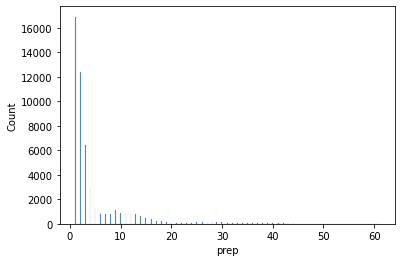

In [77]:
sns.histplot(data=bow_train[(bow_train['Class']==0)&(bow_train['prep']!=0)], x='prep')

<AxesSubplot:xlabel='prep', ylabel='Count'>

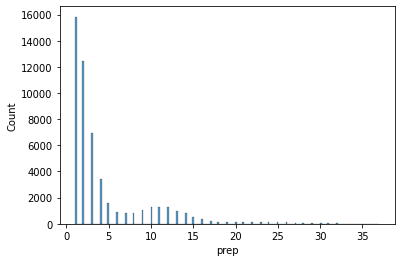

In [78]:
sns.histplot(data=bow_train[(bow_train['Class']==1)&(bow_train['prep']!=0)], x='prep')

In [ ]:
# sns.displot(data=bow_train, x='prep grnd', hue="Class", col = "Class")

In [79]:
max(bow_train.loc[bow_train['Class'] == 0]['prep'])

61

In [80]:
max(bow_train.loc[bow_train['Class'] == 1]['prep'])

37

По этому распределению мы видим что эта унирамма встречается в обеих группах практически одинаково.

In [81]:
bow_train.loc[bow_train['Class'] == 0]['prep'].median()

2.0

In [82]:
bow_train.loc[bow_train['Class'] == 1]['prep'].median()

2.0

Изобразим распределение на другом графике:

<AxesSubplot:xlabel='Class', ylabel='prep'>

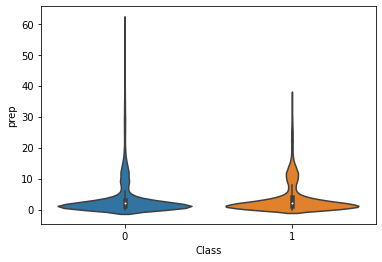

In [83]:
sns.violinplot(x="Class", y="prep", data=bow_train)

Вывод: распределение по этой биграмме визуально практически не отличается. Остальные биграммы встречаются очень в маленьком количестве, непонятно, насколько такое получится использовать. Вторая по coef биграмма встречается максимум 4 раза в одном тексте:

In [84]:
bow_train[bow_train['comp none']!=0]['comp none'].count()

1055

<AxesSubplot:xlabel='Class', ylabel='comp none'>

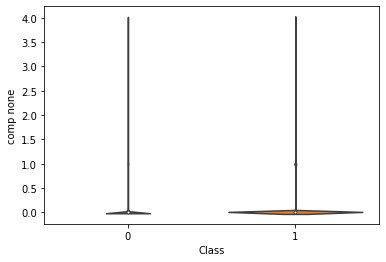

In [85]:
sns.violinplot(x="Class", y="comp none", data=bow_train)

<AxesSubplot:xlabel='comp none', ylabel='Count'>

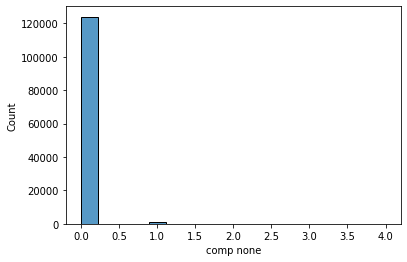

In [86]:
sns.histplot(data=bow_train, x='comp none')
# по второй биграмме делаем вывод что практически во всех текстах их 0, и в очень маленьком количестве текстов она от 1 до 4

<AxesSubplot:xlabel='comp none', ylabel='Count'>

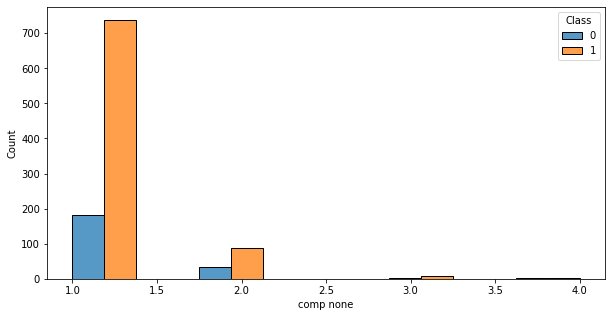

In [87]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,5))
sns.histplot(data=bow_train[bow_train["comp none"]!=0], x="comp none", hue="Class", multiple="dodge", shrink=1,\
            bins=8)

In [88]:
a = bow_train[bow_train['comp none'] == 1]['comp none'].sum()
b = bow_train[(bow_train['comp none'] == 1) & (bow_train['Class'] == 1)]['comp none'].sum()
c = bow_train[(bow_train['comp none'] == 1) & (bow_train['Class'] == 0)]['comp none'].sum()
print(f'Биграмма "comp none" встречается 1 раз в {a} текстах')
print(f'Из них в сгенерированных текстах: {b} раз')
print(f'В human текстах: {c} раз')

Биграмма "comp none" встречается 1 раз в 920 текстах
Из них в сгенерированных текстах: 738 раз
В human текстах: 182 раз


In [89]:
a = int(bow_train[bow_train['comp none'] == 2]['comp none'].sum()/2)
b = int(bow_train[(bow_train['comp none'] == 2) & (bow_train['Class'] == 1)]['comp none'].sum()/2)
c = int(bow_train[(bow_train['comp none'] == 2) & (bow_train['Class'] == 0)]['comp none'].sum()/2)
print(f'Биграмма "comp none" встречается 2 раза в {a} текстах')
print(f'Из них в сгенерированных текстах: {b} раз')
print(f'В human текстах: {c} раз')

Биграмма "comp none" встречается 2 раза в 123 текстах
Из них в сгенерированных текстах: 89 раз
В human текстах: 34 раз


In [90]:
a = int(bow_train[bow_train['comp none'] == 3]['comp none'].sum()/3)
b = int(bow_train[(bow_train['comp none'] == 3) & (bow_train['Class'] == 1)]['comp none'].sum()/3)
c = int(bow_train[(bow_train['comp none'] == 3) & (bow_train['Class'] == 0)]['comp none'].sum()/3)
print(f'Биграмма "comp none" встречается 3 раза в {a} текстах')
print(f'Из них в сгенерированных текстах: {b} раз')
print(f'В human текстах: {c} раз')

Биграмма "comp none" встречается 3 раза в 10 текстах
Из них в сгенерированных текстах: 9 раз
В human текстах: 1 раз


In [91]:
a = int(bow_train[bow_train['comp none'] == 4]['comp none'].sum()/4)
b = int(bow_train[(bow_train['comp none'] == 4) & (bow_train['Class'] == 1)]['comp none'].sum()/4)
c = int(bow_train[(bow_train['comp none'] == 4) & (bow_train['Class'] == 0)]['comp none'].sum()/4)
print(f'Биграмма "comp none" встречается 4 раза в {a} текстах')
print(f'Из них в сгенерированных текстах: {b} раз')
print(f'В human текстах: {c} раз')

Биграмма "comp none" встречается 4 раза в 2 текстах
Из них в сгенерированных текстах: 1 раз
В human текстах: 1 раз


Проверим то же самое для 3 фичи:

<AxesSubplot:xlabel='none comp', ylabel='Count'>

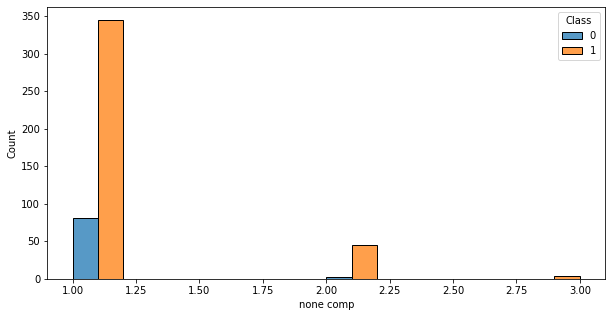

In [92]:
plt.subplots(figsize=(10,5))
sns.histplot(data=bow_train[bow_train["none comp"]!=0], x="none comp", hue="Class", multiple="dodge", shrink=1)

Тоже работает. Проверим для 4й:

<AxesSubplot:xlabel='pred intj', ylabel='Count'>

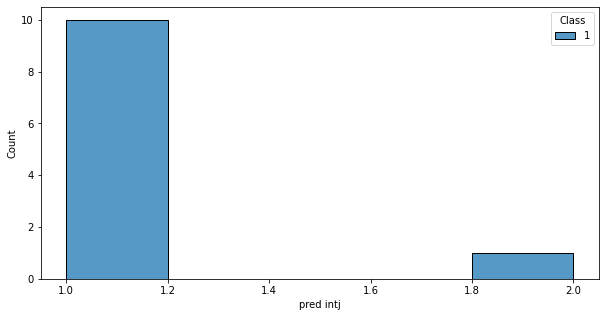

In [93]:
plt.subplots(figsize=(10,5))
sns.histplot(data=bow_train[bow_train["pred intj"]!=0], x="pred intj", hue="Class", multiple="dodge", shrink=1)

In [94]:
print(bow_human[bow_human['pred intj']!=0]['pred intj'].count())
print(bow_machine[bow_machine['pred intj']!=0]['pred intj'].count())

0
11


In [95]:
bow_train['Id'] = train['Id']

In [96]:
# посмотрим что за тексты. Это фича предикатив междометие. Но во всех примерах неправильно присвоен тэг.
bow_train[bow_train['pred intj']!=0]

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb numr,verb prcl,verb pred,verb prep,verb prtf,verb prts,verb verb,Class,Количество слов,Id
5295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,17.0,116637
10018,8,3,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,80.0,124861
41570,8,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,82.0,44869
50990,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,85.0,87693
55396,8,1,0,2,0,1,0,0,0,0,...,0,0,0,2,0,0,0,1,84.0,95389
56189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,7.0,96729
57448,14,2,0,0,0,1,0,0,0,0,...,0,0,1,7,0,0,0,1,217.0,98807
58719,20,2,0,0,0,0,0,0,1,0,...,0,0,0,2,0,0,0,1,264.0,100978
99189,9,1,0,0,0,2,0,0,0,0,...,0,0,0,2,0,0,0,1,75.0,9373
123236,15,0,0,0,0,1,0,0,0,0,...,0,0,0,5,0,0,0,1,327.0,158125


In [98]:
# Human:
print(train['Text'].iloc[5295],'\n',train['POS_Text'].iloc[5295])
# здесь это "надо есть"
print(train['Text'].iloc[10018],'\n',train['POS_Text'].iloc[10018])
# "надо есть"
# Machine:
print(train['Text'].iloc[41570],'\n',train['POS_Text'].iloc[41570])
# надо есть
print(train['Text'].iloc[50990],'\n',train['POS_Text'].iloc[50990])
# можно есть

Вам не надо есть деньги, а отдать их их сестрице, они их приготовили с вечера, утром хвать-похвать. 
 ['NPRO', 'PRCL', 'PRED', 'INTJ', 'NOUN', 'CONJ', 'INFN', 'NPRO', 'NPRO', 'NOUN', 'NPRO', 'NPRO', 'VERB', 'PREP', 'NOUN', 'ADVB', 'INFN']
Территория муниципального образования город Тольятти, ул. Советская 

 Как вы думаете почему люди стали больше пить? Да потому что они перестали быть здоровыми! :) В результате этого и происходит то самое пресловутое "вредное" население планеты Земля... :( А ведь это так просто - не надо есть сладкое на ночь (хотя бы по утрам), можно выпить стакан сока перед сном или съесть кусочек хлеба с маслом вместо колбасы. ;) И еще: если человек ест много фруктов в день за завтраком – он здоровее всех остальных людей во 
 ['NOUN', 'ADJF', 'NOUN', 'NOUN', 'NOUN', None, 'ADJF', 'CONJ', 'NPRO', 'VERB', 'ADVB', 'NOUN', 'VERB', 'COMP', 'INFN', 'PRCL', 'ADVB', 'CONJ', 'NPRO', 'VERB', 'INFN', 'ADJF', None, 'PREP', 'NOUN', 'NPRO', 'CONJ', 'VERB', 'CONJ', 'ADJF', 'ADJF',

Штош, получается так, но она всего встречается в 11 текстах, не думаю что это показательно. К тому же токенизатор всё неправильно определил. Проверим 5-ю фичу:

<AxesSubplot:xlabel='comp advb', ylabel='Count'>

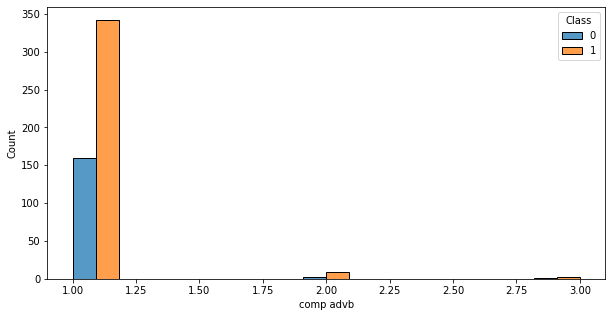

In [107]:
plt.subplots(figsize=(10,5))
sns.histplot(data=bow_train[bow_train["comp advb"]!=0], x="comp advb", hue="Class", multiple="dodge", shrink=1)

У неё тоже видна разница в human и machine. Она встречается в относительно большом количестве текстов (500+), то есть может быть можно использовать. Проверим количество:

In [108]:
print(bow_human[bow_human['comp advb']!=0]['comp advb'].count())
print(bow_machine[bow_machine['comp advb']!=0]['comp advb'].count())
print (bow_human[bow_human['comp advb']!=0]['comp advb'].count()+bow_machine[bow_machine['comp advb']!=0]['comp advb'].count())

163
353
516


Вывод: мне кажется можно использовать 1,2,3 и 5 фичу из списка отранжированных по coef биграмм. У 1-й отличается средняя частота употребления, при этом общее число текстов, в которых она есть, и общее количество биграмм не отличается для Н и М. Остальные проанализированные биграммы имеют большую разницу в частоте употребления в Н и М.
У остальных биграмм coef меньше 1, не стала их анализировать.

Проверим по частотам.

In [110]:
# делаем столбцы с частотами фичей 1,2,3,5
bow_train['prep_freq'] = bow_train['prep']/bow_train['Количество слов']
bow_train['comp_none_freq'] = bow_train['comp none']/bow_train['Количество слов']
bow_train['none_comp_freq'] = bow_train['none comp']/bow_train['Количество слов']
bow_train['comp_advb_freq'] = bow_train['comp advb']/bow_train['Количество слов']

bow_train[bow_train['prep']!=0]

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
0,12,2,0,2,0,0,0,0,0,0,...,0,0,0,0,85.0,107559,0.105882,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,11.0,107562,0.272727,0.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,15.0,107563,0.133333,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,107567,0.250000,0.0,0.0,0.0
5,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,20.0,107568,0.050000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125053,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,16.0,161275,0.187500,0.0,0.0,0.0
125054,9,0,0,0,0,2,0,0,0,1,...,0,0,0,1,96.0,161279,0.093750,0.0,0.0,0.0
125057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,9.0,161286,0.111111,0.0,0.0,0.0
125058,4,0,0,0,0,0,0,0,0,0,...,0,0,0,1,19.0,161290,0.105263,0.0,0.0,0.0


Анализируем 1-ю униграмму, prep

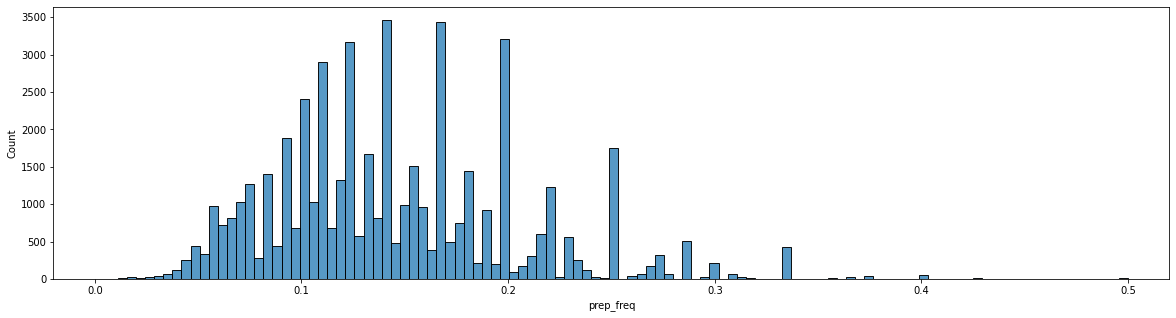

In [111]:
fig, ax = plt.subplots(figsize=(20,5))
try:
    sns.histplot(data=bow_train[(bow_train['prep_freq'] != 0) & (bow_train['Class'] == 0)], x='prep_freq')
    ax.set_xlim(-0.02,0.52)
    ax.set_xticks(range(0,0.5))
except TypeError:
    pass

<AxesSubplot:xlabel='prep_freq', ylabel='Count'>

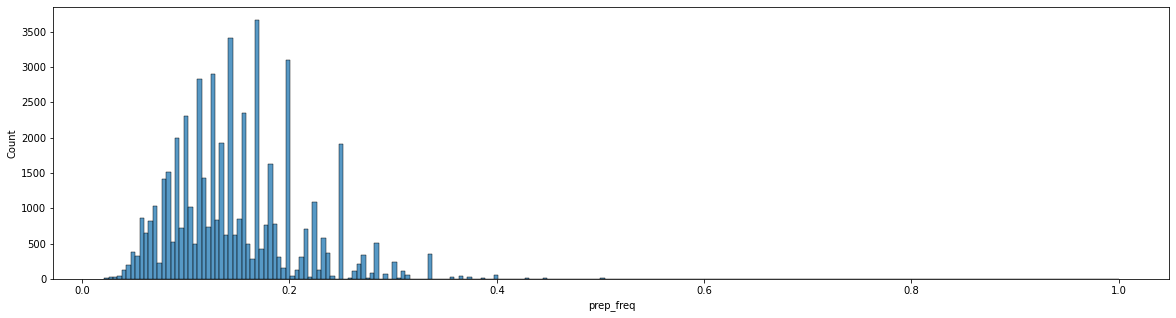

In [112]:
plt.subplots(figsize=(20,5))
sns.histplot(data=bow_train[(bow_train['prep_freq'] != 0) & (bow_train['Class'] == 1)], x='prep_freq')

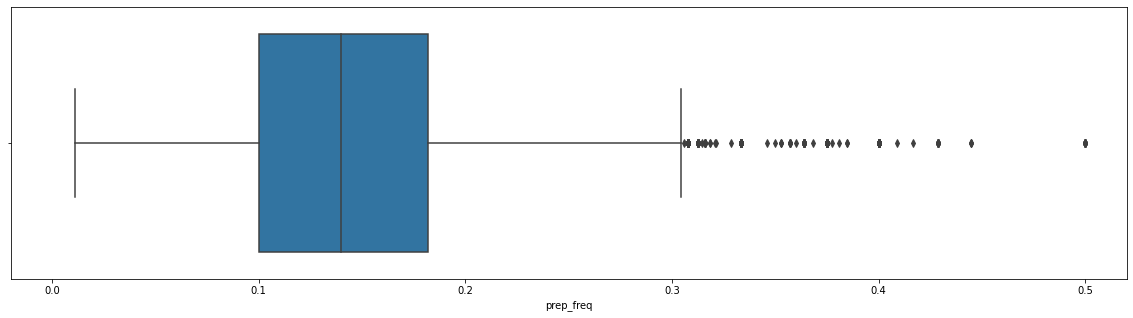

In [113]:
fig, ax = plt.subplots(figsize=(20,5))
try:
    sns.boxplot(data=bow_train[(bow_train['prep_freq'] != 0) & (bow_train['Class'] == 0)], x='prep_freq')
    ax.set_xlim(-0.02,0.52)
    ax.set_xticks(range(0,0.5))
except TypeError:
    pass

<AxesSubplot:xlabel='prep_freq'>

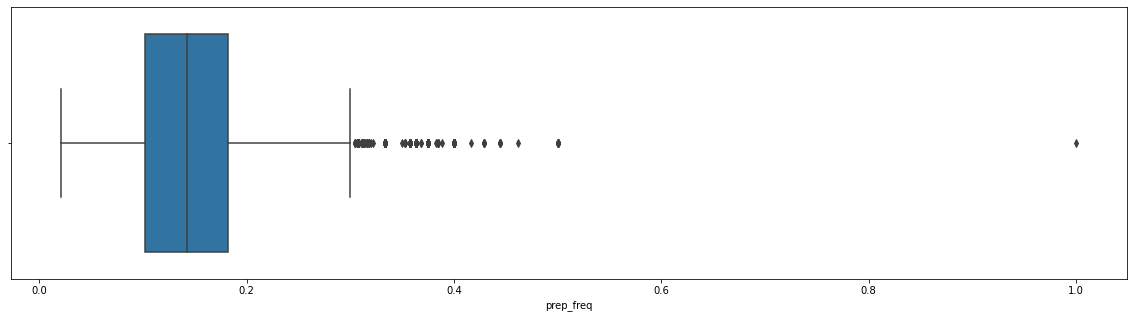

In [114]:
plt.subplots(figsize=(20,5))
sns.boxplot(data=bow_train[(bow_train['prep_freq'] != 0) & (bow_train['Class'] == 1)], x='prep_freq')

Получается что распределение частот у этой униграммы очень похожее, просто в машинных текстах есть большие выбросы. Похожее респределение показывает фактически одинаковое значение медиан:

In [115]:
print(bow_train[(bow_train['prep_freq'] != 0) & (bow_train['Class'] == 0)]['prep_freq'].median())
print(bow_train[(bow_train['prep_freq'] != 0) & (bow_train['Class'] == 1)]['prep_freq'].median())

0.13976146875146733
0.14285714285714285


In [116]:
max(bow_train[bow_train['Class'] == 0]['prep_freq'])

0.5

prep означает "предлог"
Пример текстов Н и М, где максимальная частота этой униграммы:

In [117]:
bow_train[bow_train['prep_freq']==max(bow_train[bow_train['Class'] == 0]['prep_freq'])]

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,107632,0.5,0.0,0.0,0.0
5520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,12.0,117033,0.5,0.0,0.0,0.0
8746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,122588,0.5,0.0,0.0,0.0
12938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2.0,129840,0.5,0.0,0.0,0.0
16603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,4.0,189895,0.5,0.0,0.0,0.0
19240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,6.0,194399,0.5,0.0,0.0,0.0
31163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,214946,0.5,0.0,0.0,0.0
45251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,51236,0.5,0.0,0.0,0.0
45756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,52062,0.5,0.0,0.0,0.0
48669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,10.0,83727,0.5,0.0,0.0,0.0


In [118]:
bow_train['prep'][117159]

7

In [120]:
print(train['Text'][117159])

Он ходил с О.В., ходил к Л., обедал; были разговоры с У.В.


In [122]:
train['sent_POS_Text'][117159]

'NPRO VERB PREP PREP PREP VERB PREP NOUN VERB VERB NOUN PREP PREP PREP'

In [123]:
max(bow_train[bow_train['Class'] == 1]['prep_freq'])

1.0

In [124]:
bow_train[bow_train['prep_freq']==max(bow_train[bow_train['Class'] == 1]['prep_freq'])]

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
95714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,9.0,3378,1.0,0.0,0.0,0.0


In [125]:
bow_train[(bow_train['prep_freq'] >= 0.1)&(bow_train['Class'] == 0)]\
.sort_values (by='prep_freq', ascending=False).head(5)

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
45756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,52062,0.5,0.0,0.0,0.0
72050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6.0,177664,0.5,0.0,0.0,0.0
31163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,214946,0.5,0.0,0.0,0.0
12938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2.0,129840,0.5,0.0,0.0,0.0
45251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,51236,0.5,0.0,0.0,0.0


In [127]:
print(train['Text'][45756])
print(train['Text'][72050])
print(train['Text'][31163])
print(train['Text'][12938])
print(train['Text'][45251])

«О Аллах (о Господи)!
В Университете — на заседании по программе.
Из Пелища в Речицы.
-- С рестораном".
Из Рубежевичи в Волму.


In [131]:
# посмотрим что в других самых частотных М текстах:
# bow_train[(bow_train['prep_grnd_freq'] >= 0.1)&(bow_train['Class'] == 1)]\
# .sort_values (by='prep_grnd_freq', ascending=False).head(5)

In [132]:
# print(train['Text'][59346])
# print(train['Text'][32848])
# print(train['Text'][33750])
# print(train['Text'][71289])
# print(train['Text'][14549])

In [ ]:
# print(data['text'][58148])
# print(train['sent_POS_text'][58148])
# bow_train.loc[58148][bow_train.loc[58148]!=0]

Проверим вторую биграмму, 'comp none'.

In [134]:
bow_train[(bow_train['comp_none_freq'] > 0)&(bow_train['Class'] == 1)]\
.sort_values (by='comp_none_freq', ascending=False).head(5)

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
59346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,5.0,102056,0.0,0.200000,0.0,0.0
33750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,6.0,31347,0.0,0.166667,0.0,0.0
32848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,6.0,29821,0.0,0.166667,0.0,0.0
71289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,6.0,176256,0.0,0.166667,0.0,0.0
14549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,7.0,132599,0.0,0.142857,0.0,0.0


In [136]:
# здесь должна быть пара компаратив - неопределенный POS
# Machine:
print(train['Text'][59346],'\n',train['POS_Text'][59346],'\n')
print(train['Text'][33750],'\n',train['POS_Text'][33750],'\n')
print(train['Text'][32848],'\n',train['POS_Text'][32848],'\n')
print(train['Text'][71289],'\n',train['POS_Text'][71289],'\n')
print(train['Text'][14549],'\n',train['POS_Text'][14549],'\n')

Что больше — Токио или Кобе? 
 ['CONJ', 'COMP', None, 'NOUN', 'CONJ', 'NOUN'] 

Он играет лучше piano, чем я. 
 ['NPRO', 'VERB', 'COMP', None, 'CONJ', 'NPRO'] 

Кто бегает быстрее, Юми или Кейко? 
 ['NPRO', 'VERB', 'COMP', None, 'CONJ', 'NOUN'] 

Сегодня гостиница больше 50 лет существует. 
 ['ADVB', 'NOUN', 'COMP', None, 'NOUN', 'VERB'] 

Это лучше 100 друзей, чем 100 рублей. 
 ['PRCL', 'COMP', None, 'NOUN', 'CONJ', None, 'NOUN'] 



Мы сталкиваемся с несколькими фактами:
Тире воспринимается как слово, которому надо присвоить POS-тэг.
None фиксирует внезапный английский, но я не думаю что в контексте биграмм это показательно. Надо посмотреть распределение по None отдельно.
Некоторые цифры воспринимаются как None, это путает классификатор.

In [137]:
# Human
bow_train[(bow_train['comp_none_freq'] > 0)&(bow_train['Class'] == 0)]\
.sort_values (by='comp_none_freq', ascending=False).head(5)

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
36614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6.0,36375,0.000000,0.166667,0.0,0.0
102244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6.0,14566,0.000000,0.166667,0.0,0.0
86391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6.0,67861,0.166667,0.166667,0.0,0.0
25609,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13.0,205302,0.076923,0.153846,0.0,0.0
48653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7.0,83696,0.000000,0.142857,0.0,0.0


In [138]:
# Human
print(train['Text'][36614],'\n',train['POS_Text'][36614],'\n')
print(train['Text'][102244],'\n',train['POS_Text'][102244],'\n')
print(train['Text'][86391],'\n',train['POS_Text'][86391],'\n')
print(train['Text'][25609],'\n',train['POS_Text'][25609],'\n')
print(train['Text'][48653],'\n',train['POS_Text'][48653],'\n')

Сегодня занятия шли лучше — 15 страниц. 
 ['ADVB', 'NOUN', 'VERB', 'COMP', None, None, 'NOUN'] 

Количество выписанных значительно больше - 504 человека. 
 ['NOUN', 'PRTF', 'ADVB', 'COMP', None, 'NOUN'] 

Что дальше -- Мы ехали на трамвае. 
 ['CONJ', 'COMP', None, 'NPRO', 'VERB', 'PREP', 'NOUN'] 

Фортуново число для pn# всегда больше pn и все его делители больше pn. 
 ['ADVB', 'NOUN', 'PREP', None, 'ADVB', 'COMP', None, 'CONJ', 'ADJF', 'NPRO', 'NOUN', 'COMP', None] 

Когда мы были сильнее — тогда или теперь? 
 ['CONJ', 'NPRO', 'VERB', 'COMP', None, 'ADVB', 'CONJ', 'ADVB'] 



Здесь тоже просто проблемы с присвоением тегов в основном. Тире, непонятные символы (хотя это Human!).

Посмотрим 5 фичу:

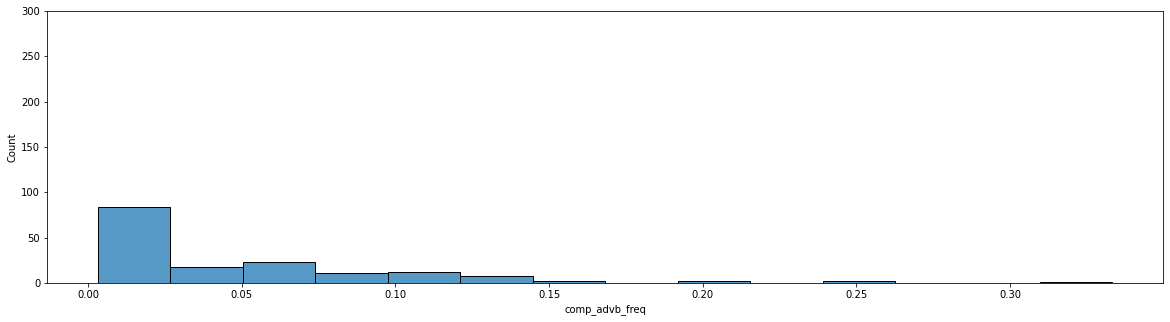

In [139]:
fig, ay = plt.subplots(figsize=(20,5))
try:
    sns.histplot(data=bow_train[(bow_train['comp_advb_freq'] != 0) & (bow_train['Class'] == 0)], x='comp_advb_freq')
    ay.set_ylim(0,300)
#     ay.set_yticks(range(0,300))
except TypeError:
    pass

<AxesSubplot:xlabel='comp_advb_freq', ylabel='Count'>

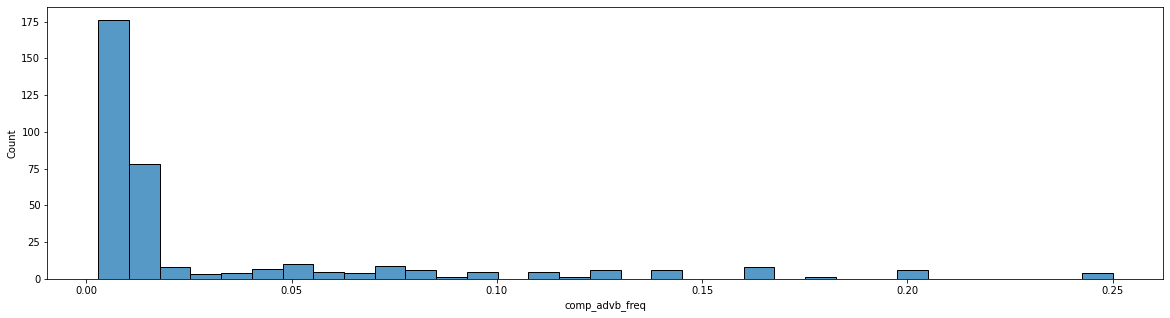

In [140]:
plt.subplots(figsize=(20,5))
sns.histplot(data=bow_train[(bow_train['comp_advb_freq'] != 0) & (bow_train['Class'] == 1)], x='comp_advb_freq')

In [141]:
a = bow_train[(bow_train['comp_advb_freq'] > 0)&(bow_train['comp_advb_freq'] <= 0.005)]['comp_advb_freq'].count()
b = bow_train[(bow_train['comp_advb_freq'] > 0)&(bow_train['comp_advb_freq'] <= 0.005) & (bow_train['Class'] == 1)]['comp_advb_freq'].count()
c = bow_train[(bow_train['comp_advb_freq'] > 0)&(bow_train['comp_advb_freq'] <= 0.005) & (bow_train['Class'] == 0)]['comp_advb_freq'].count()
print(f'Биграмма "comp advb" встречается с частотой от 0 до 0.005 в {a} текстах')
print(f'Из них в сгенерированных текстах: {b} раз')
print(f'В human текстах: {c} раз')

Биграмма "comp advb" встречается с частотой от 0 до 0.005 в 171 текстах
Из них в сгенерированных текстах: 116 раз
В human текстах: 55 раз


In [142]:
a = bow_train[(bow_train['comp_advb_freq'] > 0.005)&(bow_train['comp_advb_freq'] <= 0.01)]['comp_advb_freq'].count()
b = bow_train[(bow_train['comp_advb_freq'] > 0.005)&(bow_train['comp_advb_freq'] <= 0.01) & (bow_train['Class'] == 1)]['comp_advb_freq'].count()
c = bow_train[(bow_train['comp_advb_freq'] > 0.005)&(bow_train['comp_advb_freq'] <= 0.01) & (bow_train['Class'] == 0)]['comp_advb_freq'].count()
print(f'Биграмма "comp advb" встречается с частотой от 0.005 до 0.01 в {a} текстах')
print(f'Из них в сгенерированных текстах: {b} раз')
print(f'В human текстах: {c} раз')

Биграмма "comp advb" встречается с частотой от 0.005 до 0.01 в 60 текстах
Из них в сгенерированных текстах: 45 раз
В human текстах: 15 раз


По частоте от 0 до 0.005 есть большие различия в Н и М. На бОльшей частоте уже очень мало текстов и наверное это не показательно.

In [143]:
bow_train[(bow_train['comp_advb_freq'] >= 0.04)&(bow_train['Class'] == 1)]\
.sort_values (by='comp_advb_freq', ascending=False).head(5)

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
102117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,4.0,14324,0.0,0.0,0.0,0.25
110134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,4.0,135671,0.0,0.0,0.0,0.25
8908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,4.0,122879,0.0,0.0,0.0,0.25
35485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,4.0,34391,0.0,0.0,0.0,0.25
71248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,5.0,176186,0.0,0.0,0.0,0.20


In [145]:
print(train['Text'][102117],'\n',train['POS_Text'][102117],'\n')
print(train['Text'][110134],'\n',train['POS_Text'][110134],'\n')
print(train['Text'][8908],'\n',train['POS_Text'][8908],'\n')
print(train['Text'][35485],'\n',train['POS_Text'][35485],'\n')
print(train['Text'][71248],'\n',train['POS_Text'][71248],'\n')

Она намного лучше сегодня. 
 ['NPRO', 'ADVB', 'COMP', 'ADVB'] 

Горы выглядят красивее издалека. 
 ['NOUN', 'VERB', 'COMP', 'ADVB'] 

Лучше всего быть командиром. 
 ['COMP', 'ADVB', 'INFN', 'NOUN'] 

Лучше всего прозвучала серенада. 
 ['COMP', 'ADVB', 'VERB', 'NOUN'] 

Я чувствую себя лучше сегодня. 
 ['NPRO', 'VERB', 'NPRO', 'COMP', 'ADVB'] 



Частота биграммы зависит от длины предложения, поэтому как мы видим, самая большая частота получилась там, где эта биграмма встречается один раз, но просто предложение короткое. Поэтому для анализа конкретных предложений придется вернуться к 

In [146]:
bow_train[(bow_train["comp advb"]==3)&(bow_train['Class'] == 0)]

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
96513,39,5,0,3,0,1,1,0,0,0,...,0,0,3,0,267.0,4828,0.134831,0.0,0.0,0.011236


In [147]:
# Human:
print(train['Text'][96513],'\n',train['POS_Text'][96513],'\n')

Мозжинка. $$Воскресенье. 1 ч. дня$$. Сюда приехали только сегодня, в 12-ом часу. В Москве — выборы в В[ерховный] С[овет]. Погода сияющая, небольшой мороз, недавний снег и солнце. 33 года назад — февральская революция. Луцк, антресоли, ночной вестовой с нешифрованной радиограммой] из Берлина: «В[аше] благородие — нешифрованная передача». «В Петербурге революция. Тридцать тысяч душ присоединилось к восставшим. Родзянко — президент России» — это текст радио[граммы] из Науеп’а, переданный в ночь с 28-ого февраля на 1-ое марта. Начало совсем нового в мире.    
Отчетливое ясное чувство облака, собравшегося на минуту и разлетающегося. Сознание «я» — призрачное бытие такого облака как «целого». Все бежит, течет, меняется. Ничего прочного, начиная от электронов и протонов и кончая спиральными туманностями. Сомнительное постоянство «целого», о котором ни у кого никакого представления. «Я», свой мир, воспоминания, люди, близкие, знакомые, дом, квартира, книги, пейзажи, слова, сны, краски, картины

Текст огромный, поэтому можно сделать вывод, что неудивительно, что там 3 раза встречается биграмма компоратив-наречие.

Проверим Machine тексты:

In [148]:
bow_train[(bow_train["comp advb"]==3)&(bow_train['Class'] == 1)]

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
39047,41,7,0,1,0,2,0,0,0,2,...,1,0,1,1,289.0,40536,0.055363,0.0,0.0,0.010381
61522,32,1,0,3,0,2,0,0,0,1,...,0,4,1,1,352.0,105863,0.085227,0.0,0.0,0.008523


In [149]:
print(train['Text'][39047],'\n',train['POS_Text'][39047],'\n')
print(train['Text'][61522],'\n',train['POS_Text'][61522],'\n')

Вечером Слава принес починенный велосипед. Он был не новый, но все же вполне исправный и с мотором (наверное из-за этого он так быстро заработал). И еще на нем были новые покрышки – «липучки», как их называли в деревне мальчишки! Они очень нравились Славе…
С этими колесами Славка катался до тех пор пока у него совсем перестали ноги держать после аварии: нога стала короче чуть ли ни вдвое; колени стали тоньше почти наполовину от того размера который они имели при рождении Славы!.. А потом его родители купили ему машину... 
  Он купил себе новенький автомобиль марки BMW X3! Это было что -то потрясающее!!! Впечатление производила машина больше всего потому,что это была новая модель машины.И она выглядела просто фантастически.. Она действительно завораживала своей красотой : серебристой блестящей краской кузова ; серебристым блеском хромированных дисков колес.. Все выглядело таким красивым … Но главное...это конечно внешний вид автомобиля!!! Как бы красиво ты ее никогда раньше здесь НЕ уви

Они тоже очень большого размера.
Что-то мне подсказывает, что какой-то смысловой значимости мы в распределении биграмм не найдём.
Хочу еще проверить распределение по None.

In [150]:
bow_train[bow_train['none']!=0]['none'].count()

52684

In [151]:
print(bow_human[bow_human['none']!=0]['none'].count())
print(bow_machine[bow_machine['none']!=0]['none'].count())
# почти поровну, наверное это из-за тире и прочего.

27682
25002


Посмотрим на предложения, где больше всего none, в Human текстах, и посмотрим, можно ли улучшить токенизатор и тэггер.

In [152]:
bow_train[(bow_train['none'] > 0)&(bow_train['Class'] == 0)]\
.sort_values (by='none', ascending=False).head(5)['none']

79172    100
62749     81
93054     80
55223     75
76169     73
Name: none, dtype: int64

In [163]:
print(train['Text'][79172],'\n',train['POS_Text'][79172],'\n')
print(train['Text'][62749],'\n',train['POS_Text'][62749],'\n')
print(train['Text'][93054],'\n',train['POS_Text'][93054],'\n')
print(train['Text'][55223],'\n',train['POS_Text'][55223],'\n')
print(train['Text'][76169],'\n',train['POS_Text'][76169],'\n')

Завершился юбилейный турнир по смешанным единоборствам UFC 200, среди гостей которого был замечен и ирландец Конор Макгрегор, чей бой-реванш с Нейтоном Диасомnмог пройтиnв рамках этого вечера.nРезультаты UFC 200:nГлавный кард.nnАманда Нуньес победила Мишу Тейт — удушением со спины, Р1, 3:15, и стала новой чемпионкой UFC в легчайшем весеnБрок Леснар победил Марка Ханта — единогласным решением судей, (29-27, 29-27, 29-27)nnДаниэль Кормье победил Андерсона Сильву — единогласным решением судей, (30-26; 30-26; 30-26)nЖозе Альдо победил Фрэнки Эдгара — единогласным решением судей, (49-46, 49-46, 48-47)nКейн Веласкез победил Трэвиса Брауна — ТКО (удары), Р1, 4:57nПредварительный кард.nnДжулиана Пенья победила Кэт Цингано — единогласным решением судей, (29-28; 29-28; 29-28)nКелвин Гастелум победил Джонни Хендрикса — единогласным решением судей, (29-28, 30-27, 30-27)nТи Джей Диллашоу победил Рафаэля Ассунсао — единогласным решением судей, (30-27, 30-27, 30-27)nСейдж Норткатт победил Энрике Мари

Посмотрим на Machine тексты с большим количеством None:

In [154]:
bow_train[(bow_train['none'] > 0)&(bow_train['Class'] == 1)]\
.sort_values (by='none', ascending=False).head(5)#['none']

,adjf,adjf adjf,adjf adjs,adjf advb,adjf comp,adjf conj,adjf grnd,adjf infn,adjf intj,adjf none,...,verb prtf,verb prts,verb verb,Class,Количество слов,Id,prep_freq,comp_none_freq,none_comp_freq,comp_advb_freq
17312,27,1,0,0,0,0,0,0,0,1,...,0,0,0,1,330.0,191085,0.030303,0.000000,0.0,0.000000
76765,25,2,0,0,0,1,0,0,0,1,...,0,1,0,1,323.0,185740,0.065015,0.003096,0.0,0.000000
67498,25,3,0,0,0,0,0,0,0,0,...,0,1,0,1,342.0,169871,0.064327,0.002924,0.0,0.000000
32909,26,0,0,0,0,1,0,0,0,0,...,0,0,0,1,341.0,29911,0.058651,0.000000,0.0,0.000000
37751,19,2,0,1,0,1,0,0,2,3,...,0,0,0,1,324.0,38268,0.077160,0.000000,0.0,0.003086


In [155]:
print(train['Text'][17312],'\n',train['POS_Text'][17312],'\n')
print(train['Text'][76765],'\n',train['POS_Text'][76765],'\n')
print(train['Text'][67498],'\n',train['POS_Text'][67498],'\n')
print(train['Text'][32909],'\n',train['POS_Text'][32909],'\n')
print(train['Text'][37751],'\n',train['POS_Text'][37751],'\n')

Англия объявляет войну Германии
Александр Сергеевич Пушкин. 
  В России в конце XVIII века началась гражданская война между Англией и Россией, начавшаяся с убийства короля Генриха IV Английского (1713-1802) во время его пребывания у власти при малолетнем сыне Георге VI Иоанновиче Романовых[1]. В ходе этого события были убиты многие знатные лица того времени: король Георг V Брауншвейгский - граф Яков Брюс I Анжуйское королевство Польская Республика Пруссия Англо — Австрийские Нидерланды Германия Франция Англия Голландия Бельгия Люксембург Португалия Дания Швеция Испания Чехия Венгрия Румынство Словактия Болгары Италия США Канада Великобритания Австралийцы Ирландских островов Британской Индии Малайзии Новой Зеландии Австралии Тайвань Китай Индонезии Индонезия Новая Гвинеа Перу Французскую Остальную Африку Японцев Америки Индийским Океаном Тихий океан Америка Азия Европа Скандинавия Норвегии Финляндия Польша Литва Латвийскоязычная Россия Белоруссию Украину Польшу Эстонию Молдавию Беларусь

Неа взгляд различий принципиальных не увидела.

<AxesSubplot:xlabel='none', ylabel='Count'>

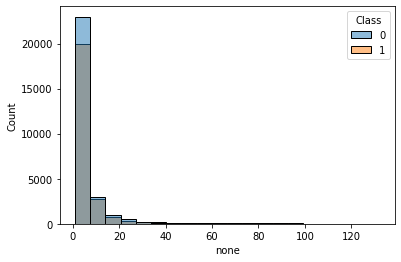

In [157]:
# plt.subplots(figsize=(10,5))
sns.histplot(data=bow_train[bow_train["none"]!=0], x="none", hue="Class", bins = 20)

<AxesSubplot:xlabel='none none', ylabel='Count'>

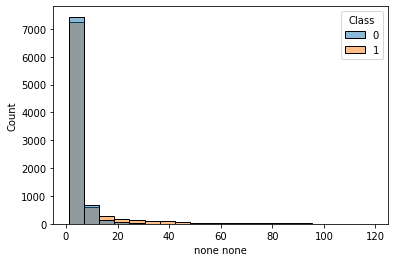

In [158]:
sns.histplot(data=bow_train[bow_train["none none"]!=0], x="none none", hue="Class", bins = 20)

In [159]:
# делаем столбец с частотой ноне:
bow_train['none_none_freq'] = bow_train['none']/bow_train['Количество слов']

<AxesSubplot:xlabel='none_none_freq', ylabel='Count'>

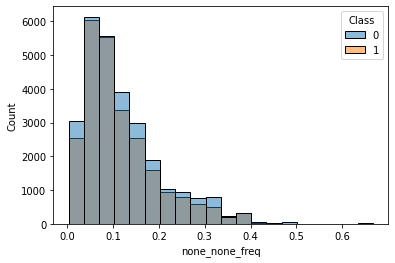

In [160]:
sns.histplot(data=bow_train[bow_train["none_none_freq"]!=0], x="none_none_freq", hue="Class", bins = 20)